In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.chdir('/home/export/soheuny/SRFinder/soheun')

features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

In [2]:
from plots import plot_sr_stats, hist_events_by_labels
import numpy as np
import torch
from fvt_classifier import FvTClassifier
from dataset import SCDatasetInfo
from events_data import EventsData
from tst_info import TSTInfo
from training_info import TrainingInfoV2
import yaml
import matplotlib.pyplot as plt

def get_is_signal(scdinfo: SCDatasetInfo, signal_filename: str):
    # Now show the answer
    is_signals = []
    for file, file_len in zip(scdinfo.files, scdinfo.get_file_lengths()):
        is_signals.append(
            np.full(file_len, True)
            if file.name == signal_filename
            else np.full(file_len, False)
        )
    is_signal = np.concatenate(is_signals)
    return is_signal



def events_from_scdinfo(scdinfo: SCDatasetInfo, features: list, signal_filename: str) -> EventsData:
    df = scdinfo.fetch_data()
    df["signal"] = get_is_signal(scdinfo, signal_filename)
    events = EventsData.from_dataframe(df, features)

    return events

In [53]:
import sys
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

plt.rcParams["lines.markersize"] = 3

verbose = False
show_plots = False
hparam_filter = {
    "experiment_name": lambda x: x in ["counting_test_v2"],
    "n_3b": 100_0000,
    "seed": lambda x: x < 10,
    # "seed": 0,
    "signal_ratio": 0.0,
}

hashes = TSTInfo.find(hparam_filter)
tst_results_summary = []

for tstinfo_hash in (pbar := tqdm.tqdm(hashes)):
    print("********************************")
    tstinfo = TSTInfo.load(tstinfo_hash)
    signal_filename = tstinfo.hparams["signal_filename"]
    seed = tstinfo.hparams["seed"]
    signal_ratio = tstinfo.hparams["signal_ratio"]        
    experiment_name = tstinfo.hparams["experiment_name"]
    
    initialize_with_fvt = True if experiment_name == "counting_test_v2" else False

    scdinfo_tst = tstinfo.scdinfo_tst
    events_tst = events_from_scdinfo(scdinfo_tst, features, signal_filename)
    
    base_fvt_hash = tstinfo.base_fvt_tinfo_hash
    base_fvt_tinfo = TrainingInfoV2.load(base_fvt_hash)
    scdinfo_base = base_fvt_tinfo.scdinfo
    events_base = events_from_scdinfo(scdinfo_base, features, signal_filename)

    print("base fvt traing 4b ratio: ", events_base.total_weight_4b / events_base.total_weight)
    
    fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{base_fvt_hash}_best.ckpt")
    fvt_model.eval()
    
    CR_fvt_hash = tstinfo.CR_fvt_tinfo_hash
    CR_fvt_tinfo = TrainingInfoV2.load(CR_fvt_hash)
    scdinfo_CR = CR_fvt_tinfo.scdinfo
    events_CR = events_from_scdinfo(scdinfo_CR, features, signal_filename)
    
    print("CR fvt traing 4b ratio: ", events_CR.total_weight_4b / events_CR.total_weight)
    
    CR_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{CR_fvt_hash}_best.ckpt")
    CR_model.eval()

    SR_stats = tstinfo.SR_stats
    SR_cut = tstinfo.SR_cut
    CR_cut = tstinfo.CR_cut
    in_SR = SR_stats >= SR_cut
    in_CR = (SR_stats < SR_cut) & (SR_stats >= CR_cut)

    probs_est_4b_base = fvt_model.predict(events_tst.X_torch).detach().cpu().numpy()[:, 1]
    probs_est_4b_CR = CR_model.predict(events_tst.X_torch).detach().cpu().numpy()[:, 1]
    rw_base = probs_est_4b_base / (1 - probs_est_4b_base)
    rw_CR = probs_est_4b_CR / (1 - probs_est_4b_CR)

    nbins = 15
    q = np.linspace(0, 1, nbins + 1)
    bins = np.quantile(SR_stats[in_CR], q)
    
    events_tst_clone = events_tst.clone()
    events_tst_clone.reweight(np.where(events_tst_clone.is_3b, rw_CR * events_tst_clone.weights, events_tst_clone.weights))
    events_CR = events_tst_clone[in_CR]
    SR_stats_CR = SR_stats[in_CR]
    hist_3b, _ = np.histogram(SR_stats_CR[events_CR.is_3b], bins=bins, weights=events_CR.weights[events_CR.is_3b])
    hist_4b, _ = np.histogram(SR_stats_CR[~events_CR.is_3b], bins=bins, weights=events_CR.weights[~events_CR.is_3b])
    midpoints = (bins[1:] + bins[:-1]) / 2

    print("CR model corrcoef: ", np.corrcoef(midpoints, hist_4b / hist_3b)[0, 1])
    print(events_tst_clone.total_weight_4b / events_tst_clone.total_weight)
    
    events_tst_clone = events_tst.clone()
    events_tst_clone.reweight(np.where(events_tst_clone.is_3b, rw_base * events_tst_clone.weights, events_tst_clone.weights))
    events_CR = events_tst_clone[in_CR]
    SR_stats_CR = SR_stats[in_CR]
    hist_3b, _ = np.histogram(SR_stats_CR[events_CR.is_3b], bins=bins, weights=events_CR.weights[events_CR.is_3b])
    hist_4b, _ = np.histogram(SR_stats_CR[~events_CR.is_3b], bins=bins, weights=events_CR.weights[~events_CR.is_3b])
    midpoints = (bins[1:] + bins[:-1]) / 2

    print("base model corrcoef: ", np.corrcoef(midpoints, hist_4b / hist_3b)[0, 1])
    print(events_tst_clone.total_weight_4b / events_tst_clone.total_weight)

    # plt.plot(midpoints, hist_4b / hist_3b)
    # plt.show()


0it [00:00, ?it/s]

1500it [00:01, 955.72it/s]
  0%|          | 0/10 [00:00<?, ?it/s]

********************************
base fvt traing 4b ratio:  0.5000431
CR fvt traing 4b ratio:  0.54739684


 10%|█         | 1/10 [00:13<01:58, 13.12s/it]

CR model corrcoef:  0.16360300131049826
0.50060666
base model corrcoef:  -0.20315974134210052
0.5012471
********************************
base fvt traing 4b ratio:  0.5003951
CR fvt traing 4b ratio:  0.55981845


 20%|██        | 2/10 [00:26<01:45, 13.23s/it]

CR model corrcoef:  0.6850420999586099
0.49646783
base model corrcoef:  0.3524467633905303
0.49888512
********************************
base fvt traing 4b ratio:  0.500284
CR fvt traing 4b ratio:  0.5478003


 30%|███       | 3/10 [00:39<01:31, 13.13s/it]

CR model corrcoef:  0.7686316816416068
0.49309587
base model corrcoef:  -0.31193500763960713
0.49652296
********************************
base fvt traing 4b ratio:  0.49989542
CR fvt traing 4b ratio:  0.5478812


 40%|████      | 4/10 [00:52<01:18, 13.09s/it]

CR model corrcoef:  0.2598517048414138
0.49617273
base model corrcoef:  -0.22647680360727257
0.4975921
********************************
base fvt traing 4b ratio:  0.4998596
CR fvt traing 4b ratio:  0.56321913


 50%|█████     | 5/10 [01:05<01:05, 13.11s/it]

CR model corrcoef:  0.352397712779881
0.5014503
base model corrcoef:  -0.4324073812042714
0.49973896
********************************
base fvt traing 4b ratio:  0.5002258
CR fvt traing 4b ratio:  0.5480893


 60%|██████    | 6/10 [01:18<00:52, 13.07s/it]

CR model corrcoef:  0.3221518280288993
0.49584514
base model corrcoef:  -0.03908722279035101
0.49960822
********************************
base fvt traing 4b ratio:  0.5001729
CR fvt traing 4b ratio:  0.5510605


 70%|███████   | 7/10 [01:32<00:39, 13.19s/it]

CR model corrcoef:  0.23476790395023553
0.50223136
base model corrcoef:  0.17800013120745067
0.5004102
********************************
base fvt traing 4b ratio:  0.50023216
CR fvt traing 4b ratio:  0.554511


 80%|████████  | 8/10 [01:45<00:26, 13.21s/it]

CR model corrcoef:  0.6247294988389673
0.49351785
base model corrcoef:  0.47475573215515693
0.49750537
********************************
base fvt traing 4b ratio:  0.5002542
CR fvt traing 4b ratio:  0.5453528


 90%|█████████ | 9/10 [01:58<00:13, 13.20s/it]

CR model corrcoef:  0.4463526315203879
0.4939231
base model corrcoef:  0.3125687426547286
0.5020362
********************************
base fvt traing 4b ratio:  0.4999038
CR fvt traing 4b ratio:  0.56416327


100%|██████████| 10/10 [02:11<00:00, 13.15s/it]

CR model corrcoef:  -0.05575326427798857
0.5057554
base model corrcoef:  0.45696015129355466
0.49703455


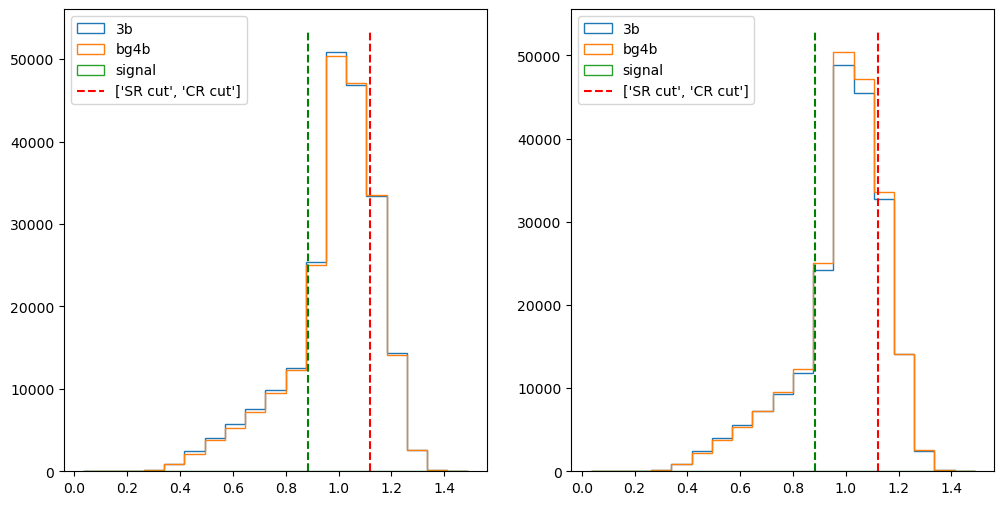

In [38]:
rw_base = (probs_est_4b_base / (1 - probs_est_4b_base))
rw_CR = (probs_est_4b_CR / (1 - probs_est_4b_CR))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
events_tst_clone = events_tst.clone()
events_tst_clone.reweight(np.where(events_tst_clone.is_3b, rw_base * events_tst_clone.weights, events_tst_clone.weights))
bins = np.linspace(np.min(SR_stats), np.max(SR_stats), 20)
hist_events_by_labels(events_tst_clone, SR_stats, bins=bins, ax=ax[0])
ymin, ymax = ax[0].get_ylim()
ax[0].vlines([SR_cut, CR_cut], ymin, ymax, colors=["red", "green"], label=["SR cut", "CR cut"], linestyle="--")
ax[0].legend()

events_tst_clone = events_tst.clone()
events_tst_clone.reweight(np.where(events_tst_clone.is_3b, rw_CR * events_tst_clone.weights, events_tst_clone.weights))
hist_events_by_labels(events_tst_clone, SR_stats, bins=bins, ax=ax[1])
ymin, ymax = ax[1].get_ylim()
ax[1].vlines([SR_cut, CR_cut], ymin, ymax, colors=["red", "green"], label=["SR cut", "CR cut"], linestyle="--")
ax[1].legend()

plt.show()

[[ 1.         -0.06894286]
 [-0.06894286  1.        ]]


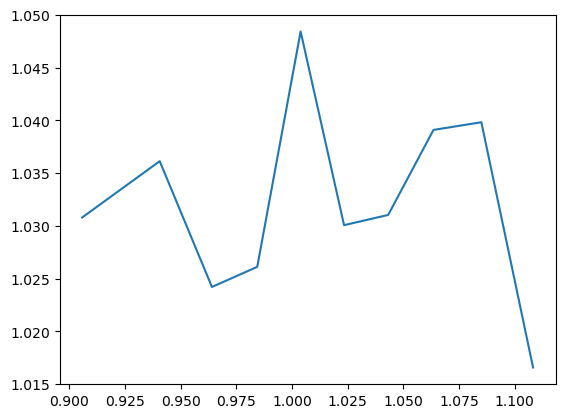

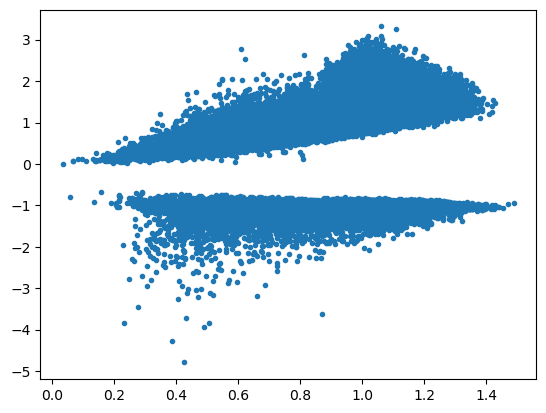

[[ 1.         -0.00748222]
 [-0.00748222  1.        ]]


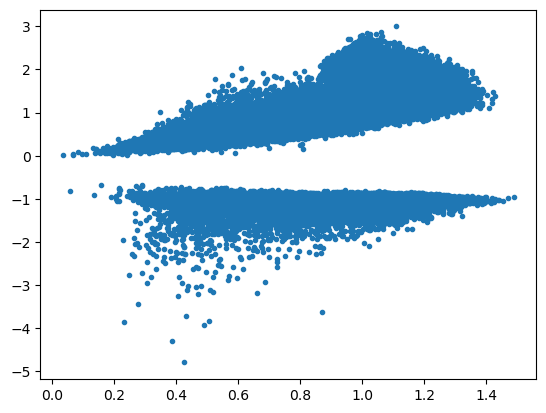

[[ 1.         -0.00716139]
 [-0.00716139  1.        ]]
[[ 1.00000000e+00 -2.53859909e-04]
 [-2.53859909e-04  1.00000000e+00]]


In [32]:
events_tst_clone = events_tst.clone()
events_tst_clone.reweight(np.where(events_tst_clone.is_3b, rw_base * events_tst_clone.weights, events_tst_clone.weights))
plt.plot(SR_stats, events_tst_clone.weights * (
    events_tst_clone.is_3b.astype(int) - events_tst_clone.is_4b.astype(int)), "o", label="base")
plt.show()

print(np.corrcoef(
    SR_stats, events_tst_clone.weights * (
    events_tst_clone.is_3b.astype(int) - events_tst_clone.is_4b.astype(int))
))

events_tst_clone = events_tst.clone()
events_tst_clone.reweight(np.where(events_tst_clone.is_3b, rw_CR * events_tst_clone.weights, events_tst_clone.weights))
plt.plot(SR_stats, events_tst_clone.weights * (
    events_tst_clone.is_3b.astype(int) - events_tst_clone.is_4b.astype(int)), "o", label="base")
plt.show()

print(np.corrcoef(
    SR_stats, events_tst_clone.weights * (
    events_tst_clone.is_3b.astype(int) - events_tst_clone.is_4b.astype(int))
))

print(np.corrcoef(
    SR_stats[in_CR], (events_tst_clone.weights * (
    events_tst_clone.is_3b.astype(int) - events_tst_clone.is_4b.astype(int)))[in_CR]
))

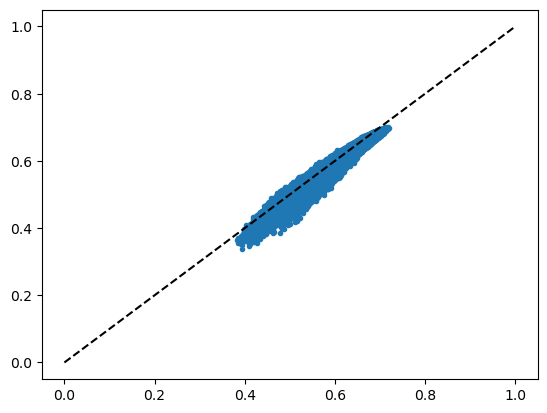

0.5670333 0.55845433


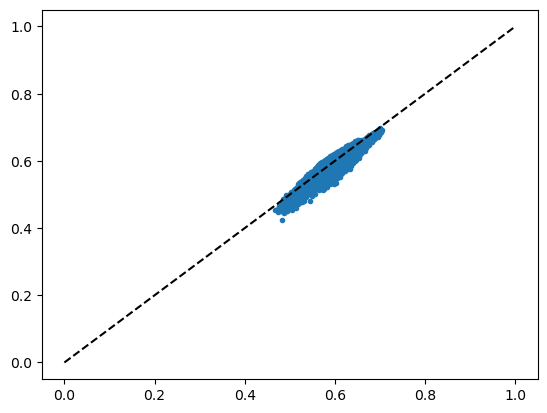

0.57936615 0.5744894


In [13]:
plt.plot(probs_est_4b_base[in_CR], probs_est_4b_CR[in_CR], 'o')
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

print(np.mean(probs_est_4b_base[in_CR]), np.mean(probs_est_4b_CR[in_CR]))

plt.plot(probs_est_4b_base[in_SR], probs_est_4b_CR[in_SR], 'o')
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

print(np.mean(probs_est_4b_base[in_SR]), np.mean(probs_est_4b_CR[in_SR]))

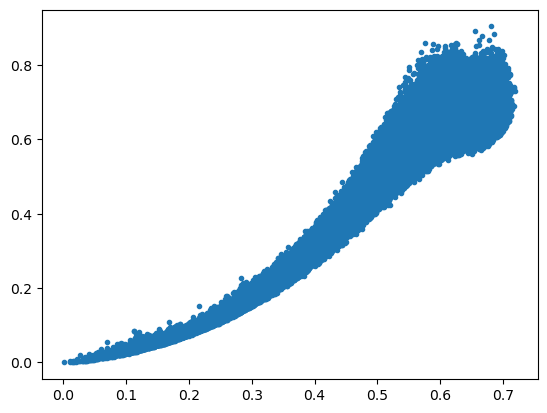

In [21]:
plt.plot(probs_est_4b_base, SR_stats * probs_est_4b_base, 'o')
plt.show()

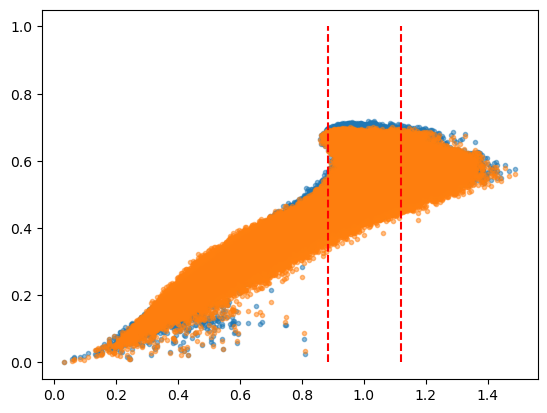

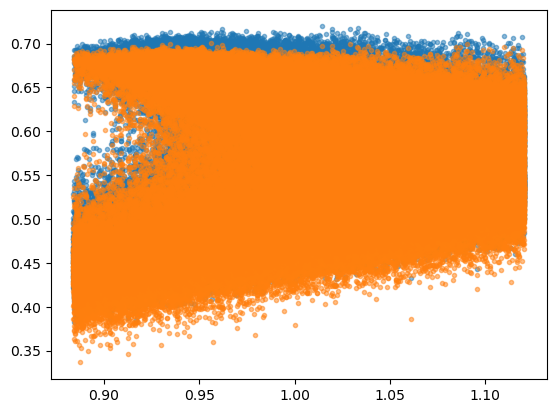

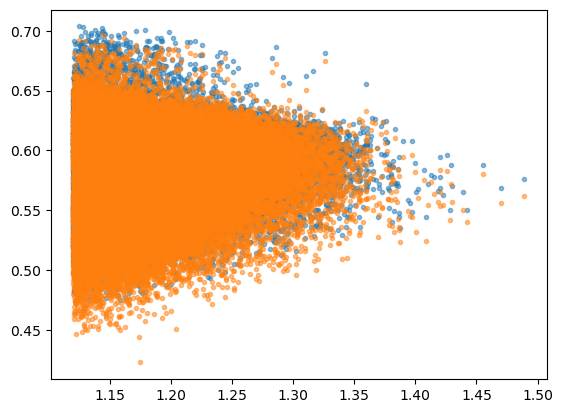

In [17]:
plt.plot(SR_stats, probs_est_4b_base, 'o', alpha=0.5, label='base')
plt.plot(SR_stats, probs_est_4b_CR, 'o', alpha=0.5, label='CR')
plt.vlines([SR_cut, CR_cut], 0, 1, colors='r', linestyles='dashed')
plt.show()

plt.plot(SR_stats[in_CR], probs_est_4b_base[in_CR], 'o', alpha=0.5, label='base')
plt.plot(SR_stats[in_CR], probs_est_4b_CR[in_CR], 'o', alpha=0.5, label='CR')
plt.show()

plt.plot(SR_stats[in_SR], probs_est_4b_base[in_SR], 'o', alpha=0.5, label='base')
plt.plot(SR_stats[in_SR], probs_est_4b_CR[in_SR], 'o', alpha=0.5, label='CR')
plt.show()

In [40]:
from dataset import generate_mother_dataset, split_scdinfo
from matplotlib.gridspec import GridSpec
from signal_region import get_SR_stats
import pytorch_lightning as pl

signal_filename = "HH4b_picoAOD.h5"
n_3b = 500_000
seed = 0
_, df_all = generate_mother_dataset(
            n_3b=n_3b,
            ratio_4b=0.5,
            signal_ratio=0.0,
            signal_filename=signal_filename,
            seed=seed,
)
df_all = df_all[~df_all["fourTag"]]
df_all["fourTag"] = np.random.randint(0, 2, df_all.shape[0]).astype(bool)

base_fvt_hparams = {
    "dim_dijet_features": 6,
    "dim_quadjet_features": 6,
    "lr": 1e-3,
    "batch_size": 1024,
    "max_epochs": 30,
    "data_seed": seed,
    "val_ratio": 0.33,
    "fit_batch_size": True,
}

train_seed = seed
# split df_all into train and test
np.random.seed(base_fvt_hparams["data_seed"])
train_idx = np.random.choice(df_all.index, int(0.5 * len(df_all)), replace=False)
df_train = df_all.loc[train_idx]
df_test = df_all.drop(train_idx)

events_train = EventsData.from_dataframe(df_train, features)
events_test = EventsData.from_dataframe(df_test, features)

events_train, events_val = events_train.split(1 - base_fvt_hparams["val_ratio"], seed=base_fvt_hparams["data_seed"])

batch_size = base_fvt_hparams["batch_size"]
train_dset = events_train.poisson_sample(batch_size * (len(events_train) // batch_size)).to_tensor_dataset()
val_dset = events_val.poisson_sample(batch_size * (len(events_val) // batch_size)).to_tensor_dataset()

events_test = events_test.poisson_sample(batch_size * (len(events_test) // batch_size))

device = torch.device("cuda:0")
num_classes = 2
dim_input_jet_features = 4
new_fvt_model = FvTClassifier(
    num_classes,
    dim_input_jet_features,
    base_fvt_hparams["dim_dijet_features"],
    base_fvt_hparams["dim_quadjet_features"],
    run_name="",
    device=torch.device("cuda:0"),
    lr=base_fvt_hparams["lr"],
)

new_fvt_model.fit(train_dset, val_dset, batch_size=base_fvt_hparams["batch_size"], 
                max_epochs=base_fvt_hparams["max_epochs"], train_seed=train_seed, 
                save_checkpoint=False)

new_fvt_model.eval()
new_fvt_model.to(device)

events_test.set_model_scores(new_fvt_model)

[rank: 0] Seed set to 0
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 8: 100%|██████████| 163/163 [00:12<00:00, 13.19it/s, v_num=68, val_loss=0.693, train_loss=0.693]


In [50]:
torch.mean(train_dset.tensors[1], dtype=torch.float32)
# torch.mean(val_dset.tensors[1], dtype=torch.float32)


tensor(0.5019)

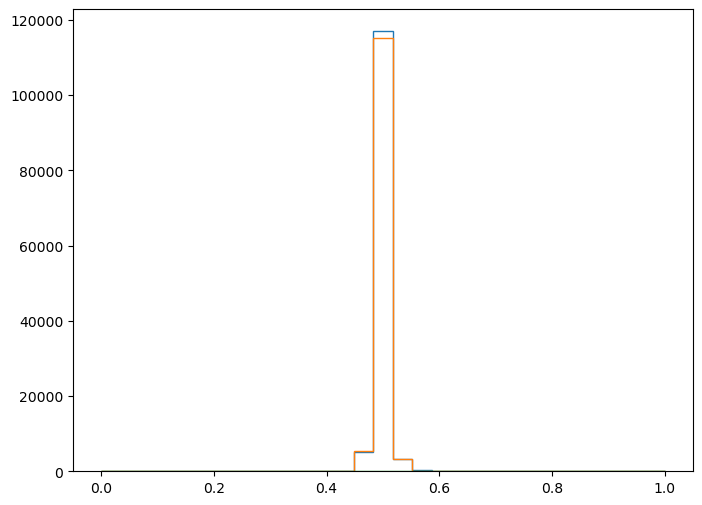

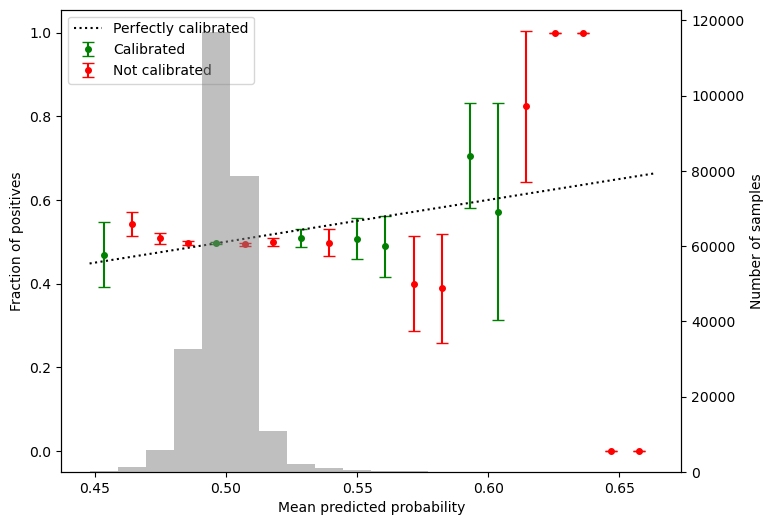

[-3.64519501]
0.4968221695696721
0.49741351722980276


In [41]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
bins = np.linspace(0, 1, 30)
hist_events_by_labels(events_test, events_test.fvt_score, ax=ax, bins=bins)
plt.show()

from plots import calibration_plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
calibration_plot(events_test.fvt_score, events_test.is_4b, ax=ax)
plt.show()

events_reweighted = events_test.clone()
probs_4b_est = events_reweighted.fvt_score
events_reweighted.reweight(
    np.where(events_reweighted.is_4b, events_reweighted.weights, events_reweighted.weights * probs_4b_est / (1 - probs_4b_est))
)
hist_values = events_reweighted.fvt_score
nbins = 1
q = np.linspace(0, 1, nbins + 1)
bins = np.quantile(hist_values, q)
hist_3b, _ = np.histogram(hist_values[events_reweighted.is_3b], bins=bins, 
                          weights=events_reweighted.weights[events_reweighted.is_3b])
hist_4b, _ = np.histogram(hist_values[events_reweighted.is_4b], bins=bins, 
                          weights=events_reweighted.weights[events_reweighted.is_4b])

sigma = (hist_4b - hist_3b) / np.sqrt(hist_3b)
print(sigma)

print(events_test.total_weight_4b / events_test.total_weight)
print(events_reweighted.total_weight_4b / events_reweighted.total_weight)

In [42]:
print(events_test.total_weight_4b / events_test.total_weight)
print(events_reweighted.total_weight_4b / events_reweighted.total_weight)

0.4968221695696721
0.49741351722980276


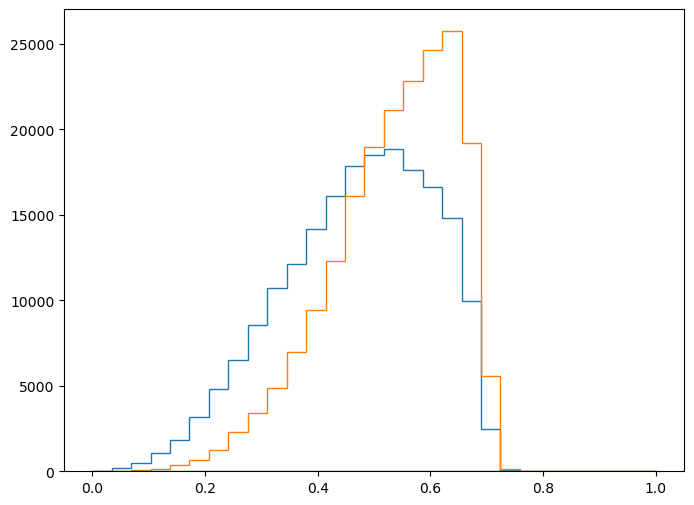

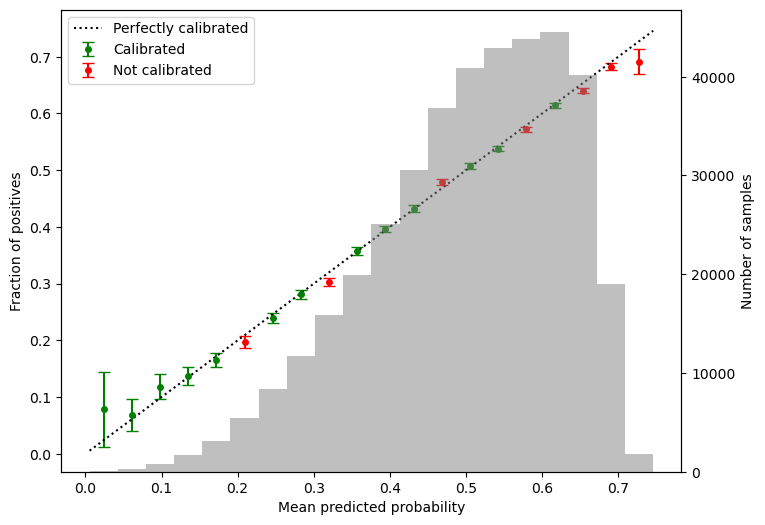

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
bins = np.linspace(0, 1, 30)
hist_events_by_labels(events_test, events_test.fvt_score, ax=ax, bins=bins)
plt.show()

from plots import calibration_plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
calibration_plot(events_test.fvt_score, events_test.is_4b, ax=ax)
plt.show()

In [34]:
events_reweighted = events_test.clone()
probs_4b_est = events_reweighted.fvt_score
events_reweighted.reweight(
    np.where(events_reweighted.is_4b, events_reweighted.weights, events_reweighted.weights * probs_4b_est / (1 - probs_4b_est))
)
hist_values = events_reweighted.fvt_score
nbins = 1
q = np.linspace(0, 1, nbins + 1)
bins = np.quantile(hist_values, q)
hist_3b, _ = np.histogram(hist_values[events_reweighted.is_3b], bins=bins, 
                          weights=events_reweighted.weights[events_reweighted.is_3b])
hist_4b, _ = np.histogram(hist_values[events_reweighted.is_4b], bins=bins, 
                          weights=events_reweighted.weights[events_reweighted.is_4b])

sigma = (hist_4b - hist_3b) / np.sqrt(hist_3b)
print(sigma)

[-6.39479871]


In [30]:
events_test.total_weight_4b / events_test.total_weight

0.49933691897684435

In [29]:
events_reweighted.total_weight_4b / events_reweighted.total_weight

0.4963905737853387

[rank: 0] Seed set to 0
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 102/102 [00:05<00:00, 18.09it/s, v_num=6, val_loss=0.662, train_loss=0.661]


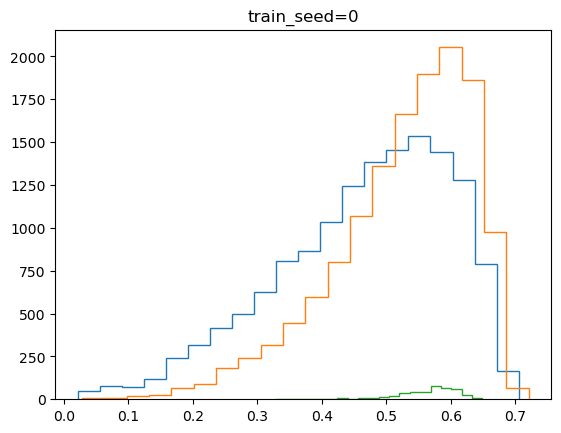

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=10` reached.
[rank: 0] Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 20: 100%|██████████| 102/102 [00:06<00:00, 16.21it/s, v_num=7, val_loss=0.662, train_loss=0.661]


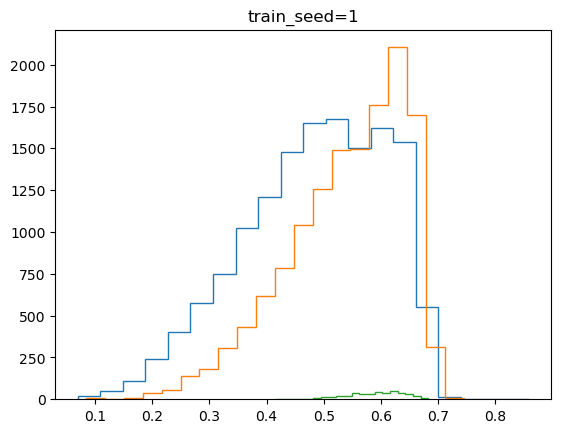

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=10` reached.
[rank: 0] Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 17: 100%|██████████| 102/102 [00:05<00:00, 18.57it/s, v_num=8, val_loss=0.662, train_loss=0.662]


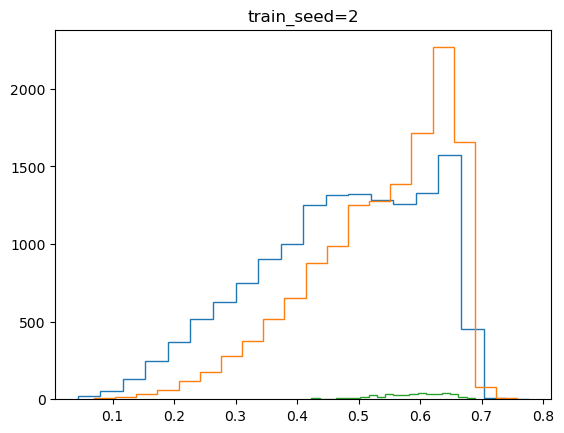

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=10` reached.
[rank: 0] Seed set to 3
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 18: 100%|██████████| 102/102 [00:05<00:00, 19.42it/s, v_num=9, val_loss=0.662, train_loss=0.661]


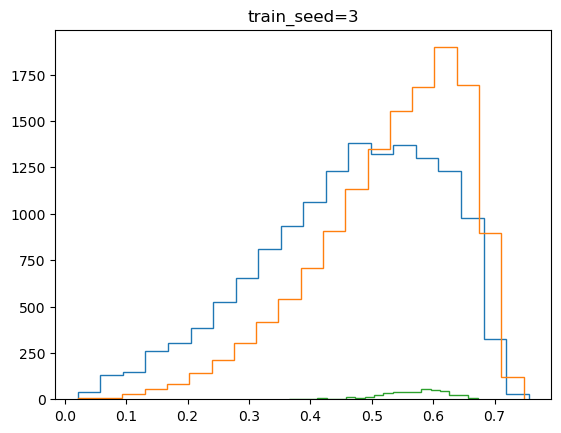

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=10` reached.
[rank: 0] Seed set to 4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 24: 100%|██████████| 102/102 [00:05<00:00, 17.02it/s, v_num=10, val_loss=0.662, train_loss=0.661]


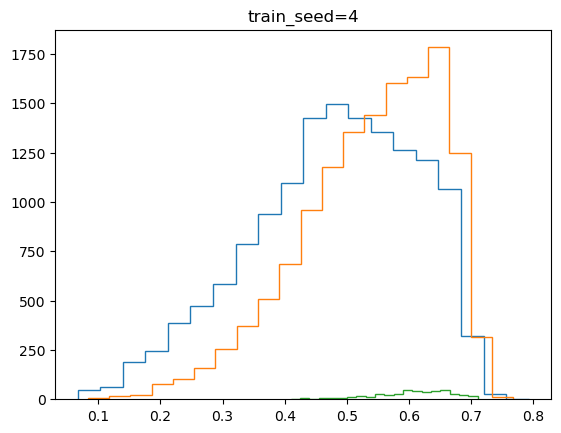

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=10` reached.
[rank: 0] Seed set to 5
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 28: 100%|██████████| 102/102 [00:05<00:00, 19.15it/s, v_num=11, val_loss=0.663, train_loss=0.660]


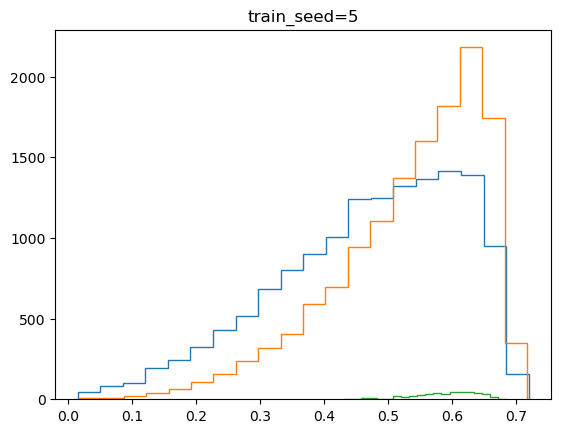

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=10` reached.
[rank: 0] Seed set to 6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 22: 100%|██████████| 102/102 [00:05<00:00, 18.76it/s, v_num=12, val_loss=0.662, train_loss=0.661]


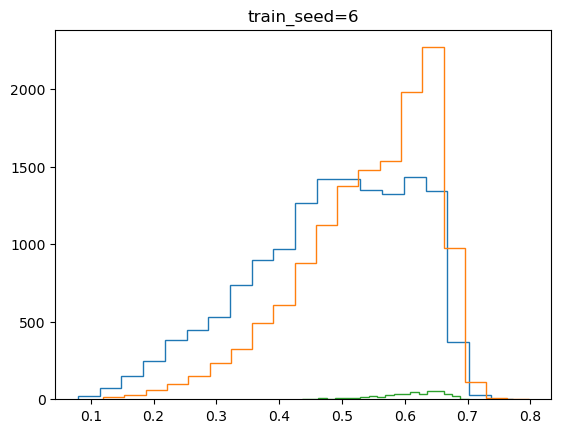

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=10` reached.
[rank: 0] Seed set to 7
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 18: 100%|██████████| 102/102 [00:05<00:00, 19.03it/s, v_num=13, val_loss=0.662, train_loss=0.661]


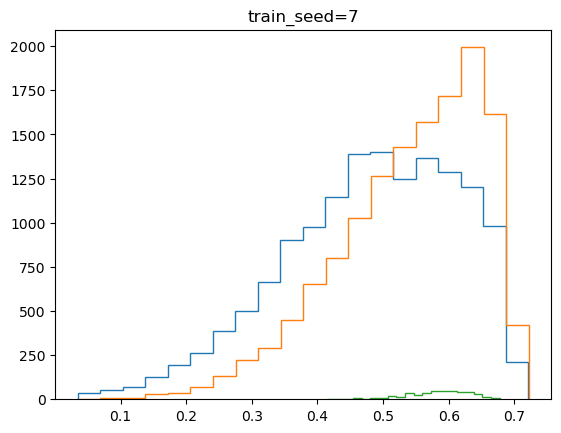

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=10` reached.
[rank: 0] Seed set to 8
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 23: 100%|██████████| 102/102 [00:05<00:00, 18.57it/s, v_num=14, val_loss=0.662, train_loss=0.661]


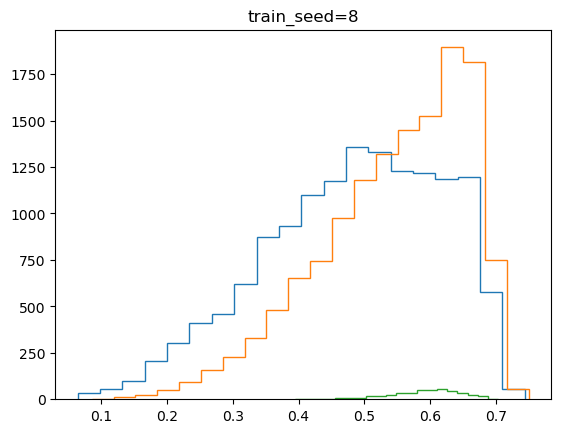

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=10` reached.
[rank: 0] Seed set to 9
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 11: 100%|██████████| 102/102 [00:06<00:00, 15.91it/s, v_num=15, val_loss=0.663, train_loss=0.662]


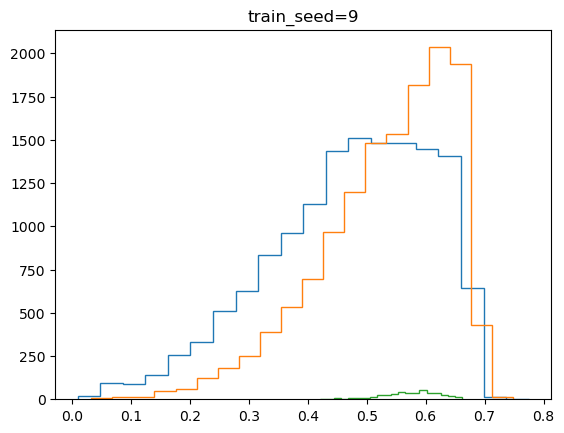

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=10` reached.


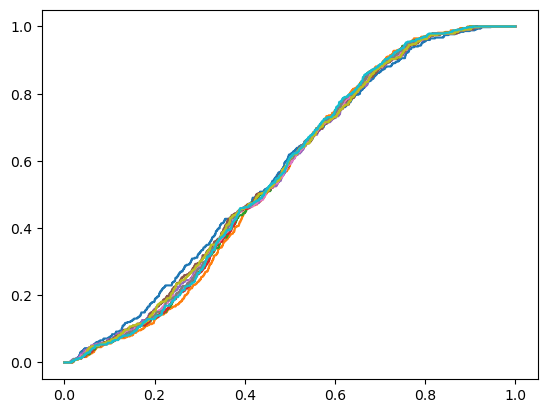

In [ ]:
fig, ax = plt.subplots()
colormap = plt.get_cmap("tab10")
for (data_seed, train_seed), SR_stats in SR_stats_dict.items():
    color = colormap(data_seed)
    plot_sr_stats(events_tst, SR_stats, ax=ax, color=color, label=f"data_seed={data_seed}, train_seed={train_seed}")
plt.show()